Идея:
* Попробовать строить модели с большим числом тем и включать регуляризатор отбора тем
* регуляризатор отбора тем нельзя включать сразу
* регуляризатор отбора тем нельзя включать вместе с регуляризатором декоррелирования


status: not done

comp: work

In [11]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')

import distances_helper as dh 
import print_helper as ph
import create_model_helper as cmh
import build_convex_hull_helper as bchh
import test_vs_original_columns_helper as tvsoch
import compare_two_models as ctm

from plot_helper import PlotMaker
from config_helper import ConfigPaths
from scipy.optimize import minimize

0.8.1


In [12]:
config = ConfigPaths('config_sample_m3.cfg')
print config.models_file_name
models_file = open(config.models_file_name, 'a')

plot_maker = PlotMaker()

batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

F:\\topic_modeling\\csi_science_collections.no_git\experiments\pn_model3\np_20_03_300\models.txt


In [13]:
def save_pickle_file(dists, filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def plot_convex_hull_topics_iterations_distribution(_phi_convex_hull):
    get_iteration_number_fn = lambda x: int(x[x.find('_', 6) + 1 : ])
    phi_convex_hull_iteration_number = [get_iteration_number_fn(col) for col in _phi_convex_hull.columns]
    phi_convex_hull_iteration_number = [(val, phi_convex_hull_iteration_number.count(val), 1.0 * phi_convex_hull_iteration_number.count(val) / len(phi_convex_hull_iteration_number)) for val in set(phi_convex_hull_iteration_number)]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[1] for x in phi_convex_hull_iteration_number], ax=ax1)
    ax1.set_title('Number of topics from each iteration')
    ax1.set_xlabel('n iteration')

    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[2] for x in phi_convex_hull_iteration_number], ax=ax2)
    ax2.set_title('Number of topics from each iteration (%)')
    ax2.set_xlabel('n iteration')
def plot_convex_hull_columns_change(iterations_info):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    ax1.plot([sum([val['n_topics_to_remove']for val in it['iterations_info_filter']]) for it in iterations_info], 
             color='r', label = 'total')
    ax1.set_title('Num columns to remove')
    get_topic_iteration_fn = lambda x: int(x[x.rfind('_') + 1 :])
    get_topic_filter_iteration_list_fn = lambda x, y: [get_topic_iteration_fn(topic) for topic in x].count(y)
    n_topics_removed_from_current_iteration = [sum([get_topic_filter_iteration_list_fn(val['removed_topics'], indx) for val in it['iterations_info_filter']]) for indx, it in enumerate(iterations_info)]
    ax1.plot(n_topics_removed_from_current_iteration, color='b', label='current iteration')
    ax1.set_xlabel('n iteration')
    ax1.legend()

    ax2.plot([val['phi_convex_hull_shape'][1] for val in iterations_info], color='r')
    ax2.set_title('Num columns of convex hull')
    ax2.set_xlabel('n iteration')
    ax2.legend()
def plot_opt_res_fun(iterations_filtering_info_name):
    %matplotlib inline
    iterations_filtering_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_filtering_info for val in item for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item for x in val['opt_res'].values()] for item in iterations_filtering_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def plot_opt_res_fun_filtering(iterations_filtering_info_name):
    iterations_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_info for val in item['iterations_info_filter'] for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item['iterations_info_filter'] for x in val['opt_res'].values()] for item in iterations_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def get_phi_granularity(phi):
    return np.mean([get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()])
def get_words_close_to_th_count(col, global_th=0.95):
    cur_sum, sum_count = 0, 0
    for val in col.sort_values()[::-1]:
        if cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_opt_x_granularity(opt):
    return np.mean([get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt.iteritems()])
def get_opt_x_close_to_th_count(opt_x, cut_th=None, global_th=0.95):
    cur_sum, sum_count = 0, 0
    opt_x_val = opt_x.copy()
    if cut_th != None:
        opt_x_val[opt_x_val < cut_th] = 0
    for val in sorted(opt_x_val)[::-1]:
        if val !=0 and cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_and_plot_granularity(phi, opt_to_original, name):
    x_count_grans = [get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean = np.mean(x_count_grans)
    x_count_grans_th = [get_opt_x_close_to_th_count(opt_res.x, cut_th=5*1e-2)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean_th = np.mean(x_count_grans_th)
    grans = [get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()]
    grans_mean = np.mean(grans) 
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    sns.distplot(x_count_grans, color='r', bins=5, ax=ax1)
    sns.distplot(x_count_grans_th, color='b', bins=5, ax=ax1)
    for topic, opt_res in opt_to_original.iteritems():
        ax2.plot(sorted(opt_res.x)[::-1])
    sns.distplot(grans, color='r', bins=5, ax=ax3)
    title = '{} {} \nx_count_grans_mean = {}; th={}'.format(name, phi.shape, x_count_grans_mean, x_count_grans_mean_th)
    ax1.set_title(title)
    title = '{} {} \ngrans_mean = {}'.format(name, phi.shape, grans_mean)
    ax3.set_title(title)

    return x_count_grans, x_count_grans_mean, grans, grans_mean

def plot_different_distances(different_distances, title):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    
    if dh.kl_dist in different_distances.keys():
        vals = different_distances[dh.kl_dist].values.flatten()
        sns.distplot(vals, color='y', ax=ax1, label='kl')
    if dh.kl_sym_dist in different_distances.keys():
        vals = different_distances[dh.kl_sym_dist].values.flatten()
        sns.distplot(vals, color='m', ax=ax1, label='kl_sym')
    
    vals = different_distances[dh.jaccard_dist].values.flatten()
    sns.distplot(vals, color='r', ax=ax2, label='jaccard')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='r', ax=ax3, label='jaccard')

    vals = different_distances[dh.cos_dist].values.flatten()
    sns.distplot(vals,  color='b', ax=ax2, label='cos')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='b', ax=ax3, label='cos')

    vals = different_distances[dh.hellinger_dist].values.flatten()
    sns.distplot(vals, color='g', ax=ax2, label='hellinger')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='g', ax=ax3, label='hellinger')
    ax1.legend()
    ax2.legend()    
    if title != '':
        fig.suptitle(title, fontsize=14, fontweight='bold')
    
def get_distances(phi):
    different_distances = {}
    distances = [dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]
    for dist_fn in distances:
        different_distances[dist_fn] = dh.calculate_distances(dist_fn, phi, phi)
    return different_distances
def save_and_plot(idx, names_list, phi_convex_hull_list, iterations_info_list, iterations_filtering_list):
    save_pickle_file(phi_convex_hull_list[idx], 'phi_convex_hull___' + names_list[idx])
    save_pickle_file(iterations_info_list[idx], 'iterations_info_list___' + names_list[idx])
    save_pickle_file(iterations_filtering_list[idx], 'iterations_filtering_list___' + names_list[idx])

    plot_convex_hull_topics_iterations_distribution(phi_convex_hull_list[idx])
    plot_convex_hull_columns_change(iterations_info_list[idx])

    distances_to_original_list = bchh.calculate_distances(DIST_FN, phi_convex_hull_list[idx], phi_original)
    opt_res_to_original_list = bchh.get_optimization_result(DIST_FN, None, phi_convex_hull_list[idx], phi_original,
                                                       distances_to_original_list[idx], n_closest_topics=N_CLOSEST_TOPICS_COUNT)
    opt_original_to_res_list = bchh.get_optimization_result(DIST_FN, None, phi_original,  phi_convex_hull_list[idx],
                                                       distances_to_original_list[idx].T, n_closest_topics=N_CLOSEST_TOPICS_COUNT)

    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_res_to_original_list[idx], names_list[idx])
    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_original_to_res_list[idx], names_list[idx])
    plot_dists(opt_res_to_original_list[idx], opt_original_to_res_list[idx], names_list[idx])
    
    different_distances = get_distances(phi_convex_hull_list[idx])
    different_distances_to_original = tvsoch.get_test_to_original_result_different_distances(phi_convex_hull_list[idx], phi_convex_hull_list[idx])
    tvsoch.plot_original_columns_count_different_distances(different_distances_to_original, n_original_columns_count=100)
    plot_different_distances(different_distances)
    return distances_to_original_list, opt_res_to_original_list, opt_original_to_res_list, different_distances, different_distances_to_original


Загрузим оригинальный sample датасет (от model3), до этого скопировав в папку с batches нужные pickle файлы модели.
Сначала провизуалируем по одной итерации каждой новой модели, а потом будем итерационно строить выпуклую оболочку для каждой модели по отдельности и затем сравнивать их. 

In [14]:
phi_original, theta_original = load_pickle_file('phi_model3.p', config.output_batches_path), load_pickle_file('theta_model3.p', config.output_batches_path)
phi_nwt_original = pd.DataFrame(0, index=phi_original.index, columns=[])
print phi_original.shape, theta_original.shape

(2216, 100) (100, 3446)


In [15]:
def check_topic_ok(topic_phi, _debug=False):
    if type(topic_phi) != np.ndarray:
        topic_phi = np.array(topic_phi)
    significant_element_th_large, significant_element_th_small = 0.01, 0.005
    significant_elements_count_large, significant_elements_count_small = 5, 10
    # sum must be != 0 (after regulizators some topics may be zero)
    topic_sum_rule = np.sum(topic_phi) > 1e-1
    # topic must have at least n words with probability greater that th
    topic_significant_elements_count_large = len(np.where(topic_phi > significant_element_th_large)[0])
    topic_significant_elements_count_small = len(np.where(topic_phi > significant_element_th_small)[0])
    topic_significant_elements_large_rule = topic_significant_elements_count_large >= significant_elements_count_large
    topic_significant_elements_small_rule = topic_significant_elements_count_small >= significant_elements_count_small
    topic_docs_count_rule = None
    if _debug:
        print('topic_sum_rule = {} [{}], topic_significant_elements_large_rule = {} [{}], topic_significant_elements_small_rule = {} [{}]' \
              .format(topic_sum_rule, np.sum(topic_phi), 
                      topic_significant_elements_large_rule, topic_significant_elements_count_large, 
                      topic_significant_elements_small_rule, topic_significant_elements_count_small))
    return topic_sum_rule and topic_significant_elements_large_rule and topic_significant_elements_small_rule

def get_distances(phi, distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]):
    different_distances = {}    
    for dist_fn in distances:
        print('Processing {}'.format(dist_fn))
        tmp = dh.calculate_distances(dist_fn, phi, phi)        
        if not np.any(tmp == np.inf) and not np.any(tmp == np.nan):
            different_distances[dist_fn] = tmp
    return different_distances
def reg_experiment(phi_original, phi_test, phi_nwt_original, phi_nwt_test):
    different_inter_distances_closest_1, different_inter_distances_closest_2 = None, None
    different_inter_distances_1, different_inter_distances_2 = None, None
    different_to_original_distances_closest_1, different_to_test_distances_closest_2 = None, None
    different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix = None, None, None
    try:
        ph.print_phi_top_tokens(phi_original, phi_test, n_top_tokens=13)
            
        models_compare_matrix = ctm.print_models_comparasion(phi_original, phi_test, phi_nwt_original, phi_nwt_test)

        % matplotlib inline
        different_inter_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_original)
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1], 
                                                               title='closest by dist inter 1')
        different_inter_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_test)
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist inter 2')


        different_inter_distances_1 = get_distances(phi_original)
        plot_different_distances(different_inter_distances_1, 'inter distances 1')
        different_inter_distances_2 = get_distances(phi_test)
        plot_different_distances(different_inter_distances_2, 'inter distances 2')


        different_to_original_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_original)
        tvsoch.plot_original_columns_count_different_distances(different_to_original_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by dist test/original')
        different_to_test_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_test)
        tvsoch.plot_original_columns_count_different_distances(different_to_test_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist original/test')


        different_to_original_opts_1 = tvsoch.get_test_to_original_opt_result_different_distances(phi_test, phi_original,
                                        distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_original_opts_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by opt test/original')
        different_to_test_opts_2 = tvsoch.get_test_to_original_opt_result_different_distances(phi_original, phi_test,
                                        distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_test_opts_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by opt original/test')


        print different_to_original_opts_1[dh.hellinger_dist][1][1]
        
    except Exception as inst:
        print('An error happened')
        print type(inst)     # the exception instance
        print inst.args      # arguments stored in .args
        print inst           
        ;
    return different_inter_distances_closest_1, different_inter_distances_closest_2, \
           different_inter_distances_1, different_inter_distances_2, \
           different_to_original_distances_closest_1, different_to_test_distances_closest_2, \
           different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix
def print_phi_top_tokens(phi, topic_name, n_top_tokens=13):
    topic = phi.loc[:, topic_name]
    top_tokens_and_weight = ' '.join([u'{0}: {1:.3f}'.format(topic, weight) for topic, weight in topic.sort_values()[::-1][0:n_top_tokens].iteritems() if weight != 0])
    print(topic_name + '| ' + top_tokens_and_weight)

# Choose models
Построить несколько моделей с отбором тем. Выводить число оставшихся необнулившихся колонок фи/тета.

In [16]:
models_count = 100
names_list, models_list = [0] * models_count, [0] * models_count
phi_list, phi_nwt_list, theta_list = [0] * models_count, [0] * models_count, [0] * models_count
phi_filtered_list, phi_nwt_filtered_list, theta_filtered_list = [0] * models_count, [0] * models_count, [0] * models_count

different_inter_distances_closest_1, different_inter_distances_closest_2 = [0] * models_count, [0] * models_count
different_inter_distances_1, different_inter_distances_2 = [0] * models_count, [0] * models_count
different_to_original_distances_closest_1, different_to_test_distances_closest_2 = [0] * models_count, [0] * models_count
different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix = [0] * models_count, [0] * models_count, [0] * models_count

# 300 topics
## decorrelator only
* без обучения сначала

In [ ]:
create_model_rch_300_1.__name__

name = model_rch_300_1_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 1.5
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 67, [u'topic_1', u'topic_7', u'topic_9', u'topic_13', u'topic_23', u'topic_28', u'topic_31', u'topic_33', u'topic_36', u'topic_43', u'topic_53', u'topic_56', u'topic_63', u'topic_66', u'topic_72', u'topic_84', u'topic_88', u'topic_101', u'topic_103', u'topic_104', u'topic_107', u'topic_114', u'topic_117', u'topic_120', u'topic_125', u'topic_126', u'topic_128', u'topic_130', u'topic_135', u'topic_136', u'topic_140', u'topic_142', u'topic_146', u'topic_152', u'topic_156', u'topic_168', u'topic_184', u'topic_191', u'topic_193', u'topic_197', u'topic_199', u'topic_204', u'topic_212', u'topic_214', u'topic_215', u'topic_225', u'topic_235', u'topic_240', u'topic_244', u'topic_247', u'topic_250', u'topic_262', u'topic_2

,phi_1,phi_2
num words,2216.00,2216.00
num topics,100.00,67.00
non zero ratio,0.96,0.98
|phi_ij == 0| / n_topics,2126.43,2164.06
|phi_ij > 0.2| / n_topics,0.23,0.58
|phi_ij > 0.1| / n_topics,0.89,1.93
|phi_ij > 0.01| / n_topics,27.16,21.25
|phi_ij > 0.05| / n_topics,2.63,4.31
|phi_ij > 0.001| / n_topics,80.26,47.10
topic_kernel_average_size,23.68,11.72


Dist fn = <function kl_sym_dist at 0x000000000BCC3908>, Processed th = 100, original columns count = 67        Processing <function jaccard_dist at 0x000000000BCC3978>
Processing <function cos_dist at 0x000000000BCC3A58>
Processing <function hellinger_dist at 0x000000000BCC3AC8>
Processing <function kl_dist at 0x000000000BCC3898>
Processing <function kl_sym_dist at 0x000000000BCC3908>
Processing <function jaccard_dist at 0x000000000BCC3978>
Processing <function cos_dist at 0x000000000BCC3A58>
Processing <function hellinger_dist at 0x000000000BCC3AC8>
Processing <function kl_dist at 0x000000000BCC3898>
Processing <function kl_sym_dist at 0x000000000BCC3908>
Dist fn = <function cos_dist at 0x000000000BCC3A58>, Processed th = 1.0, original columns count = 67           Column topic_107 not optimized
Dist fn = <function hellinger_dist at 0x000000000BCC3AC8>, Processed th = 1.0, original columns count = 67     

C:\Users\jluka\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Dist fn = <function cos_dist at 0x000000000BCC3A58>, Processed th = 1.0, original columns count = 67         Column topic_2 not optimized
Column topic_8 not optimized
Column topic_28 not optimized
Column topic_35 not optimized
Dist fn = <function hellinger_dist at 0x000000000BCC3AC8>, Processed th = 1.0, original columns count = 67     [(u'topic_1', u'topic_40', 0, 40, 0.46900337777305706), (u'topic_7', u'topic_36', 1, 36, 0.62951512254011688), (u'topic_9', u'topic_44', 2, 44, 0.41572699814576108), (u'topic_13', u'topic_5', 3, 5, 0.68857870757846285), (u'topic_23', u'topic_34', 4, 34, 0.55583346674791878), (u'topic_28', u'topic_32', 5, 32, 0.48321693722913278), (u'topic_31', u'topic_0', 6, 0, 0.70801365838786656), (u'topic_33', u'topic_2', 7, 2, 0.41438974690410024), (u'topic_36', u'topic_4', 8, 4, 0.807829668749107), (u'topic_43', u'topic_33', 9, 33, 0.65553114938995516), (u'topic_53', u'topic_3', 10, 3, 0.67443477252634121), (u'topic_56', u'topic_1', 11, 1, 0.64706938970102779), (u't

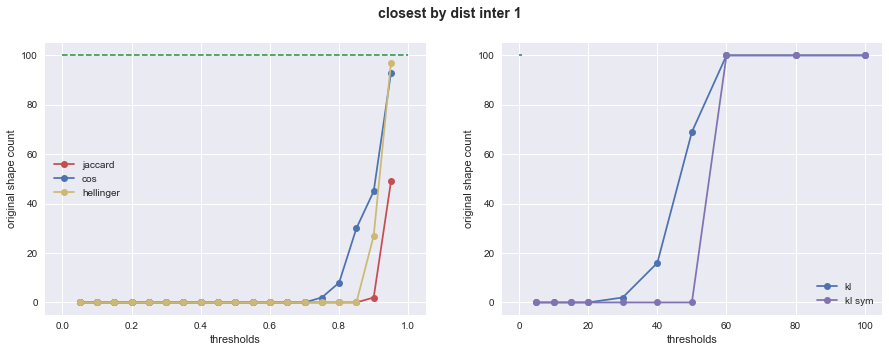

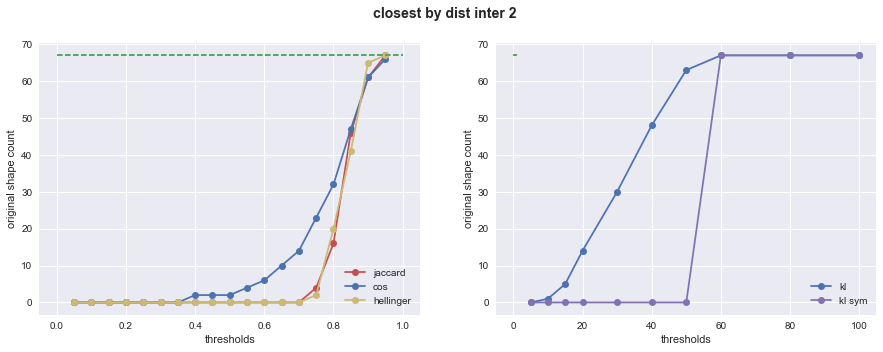

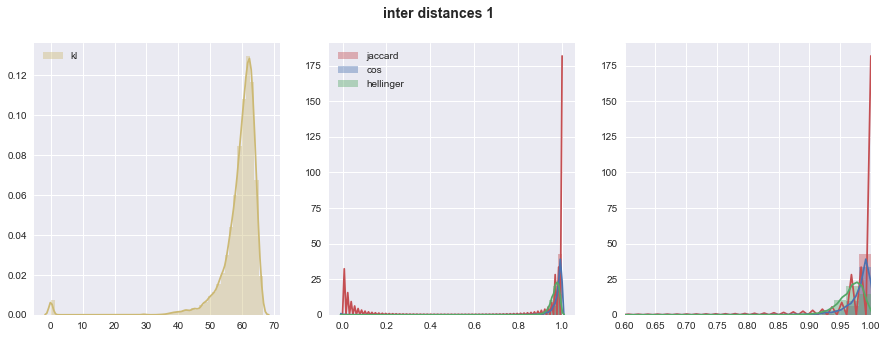

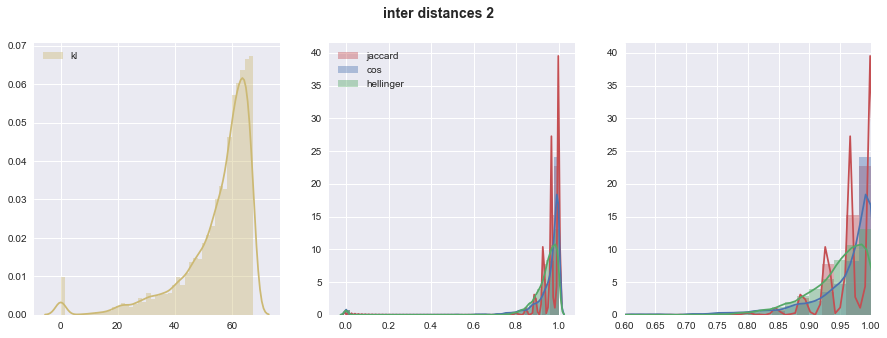

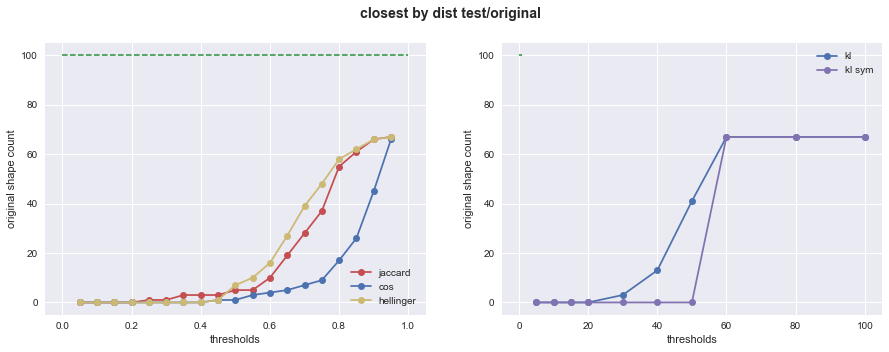

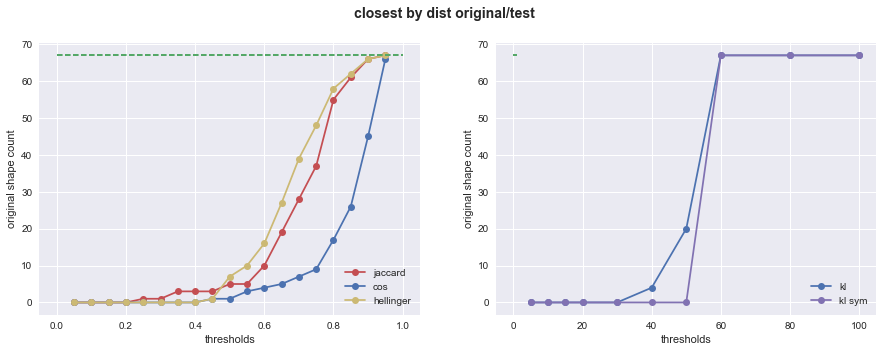

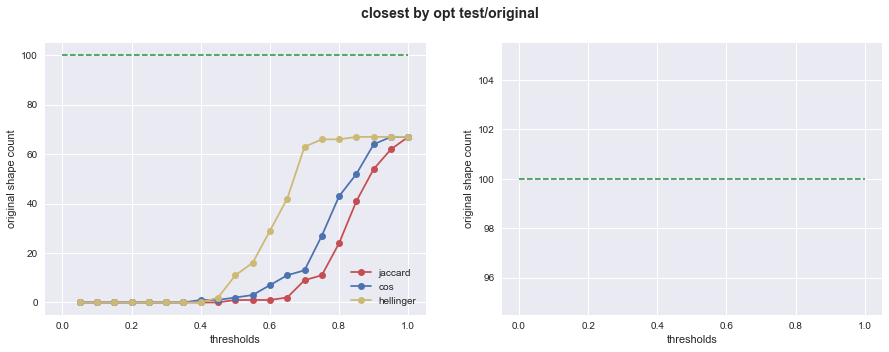

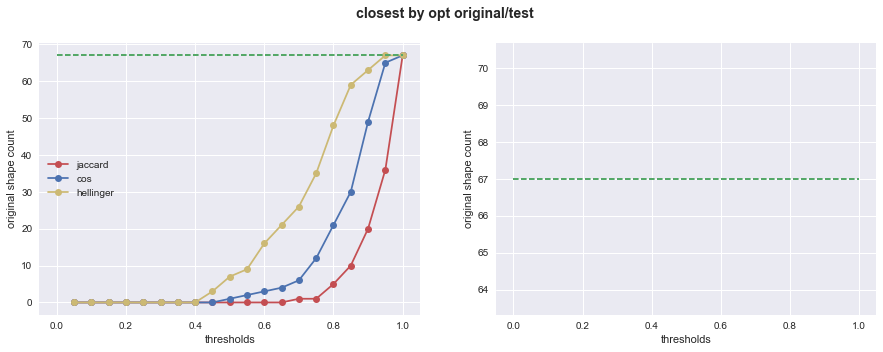

In [17]:
N_TOPICS=300

def create_model_rch_300_1(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 1.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 21
names_list[idx] = u'model_rch_300_1'
models_list[idx] = create_model_rch_300_1(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 
* **closest by dist test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by dist original/test**:  0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res original/test**: 0.2: ; 0.4: ; 0.6: ; 0.8: 

* **Выводы**: 
* **TODO**: 


побольше декоррелятор + fit model сначала

name = model_rch_300_2_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_300_2_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 3
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 210, [u'topic_0', u'topic_4', u'topic_5', u'topic_7', u'topic_8', u'topic_10', u'topic_12', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_22', u'topic_24', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_47', u'topic_49', u'topic_50', u'topic_51', u'topic_53', u'topic_54', u'topic_56', u'topic_58', u'topic_59', u'topic_62', u'topic_63', u'topic_64', u'topic_66', u'topic_68', 

,phi_1,phi_2
num words,2216.00,2216.00
num topics,100.00,210.00
non zero ratio,0.96,0.98
|phi_ij == 0| / n_topics,2126.43,2175.20
|phi_ij > 0.2| / n_topics,0.23,0.43
|phi_ij > 0.1| / n_topics,0.89,1.67
|phi_ij > 0.01| / n_topics,27.16,21.30
|phi_ij > 0.05| / n_topics,2.63,5.18
|phi_ij > 0.001| / n_topics,80.26,38.48
topic_kernel_average_size,23.68,10.50


Dist fn = <function kl_sym_dist at 0x000000000BCC3908>, Processed th = 100, original columns count = 210        Processing <function jaccard_dist at 0x000000000BCC3978>
Processing <function cos_dist at 0x000000000BCC3A58>
Processing <function hellinger_dist at 0x000000000BCC3AC8>
Processing <function kl_dist at 0x000000000BCC3898>
Processing <function kl_sym_dist at 0x000000000BCC3908>
Processing <function jaccard_dist at 0x000000000BCC3978>
Processing <function cos_dist at 0x000000000BCC3A58>
Processing <function hellinger_dist at 0x000000000BCC3AC8>
Processing <function kl_dist at 0x000000000BCC3898>
Processing <function kl_sym_dist at 0x000000000BCC3908>
Dist fn = <function cos_dist at 0x000000000BCC3A58>, Processed th = 1.0, original columns count = 100           Column topic_7 not optimized
Column topic_28 not optimized
Column topic_32 not optimized
Column topic_43 not optimized
Column topic_53 not optimized
Column topic_77 not optimized
Column topic_101 not optimized
Column topic

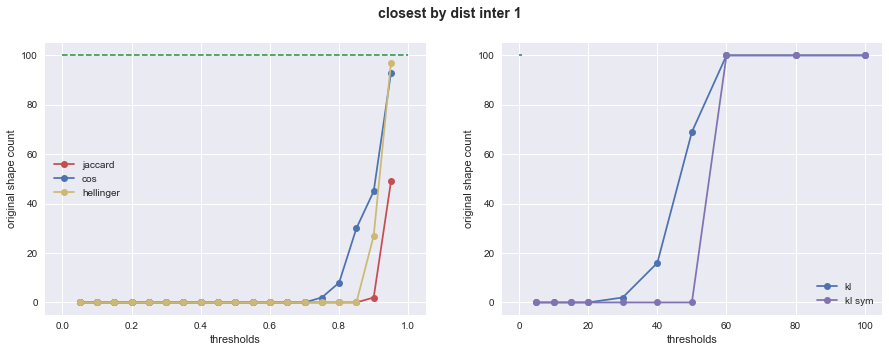

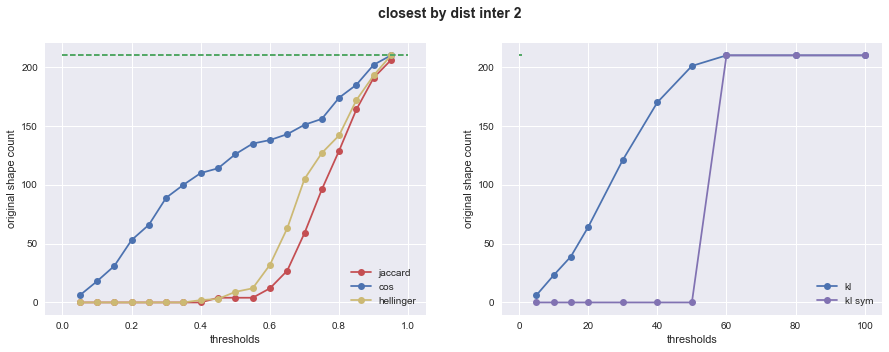

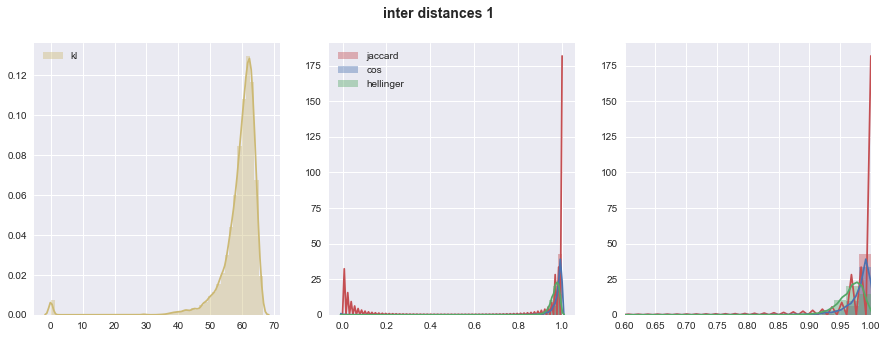

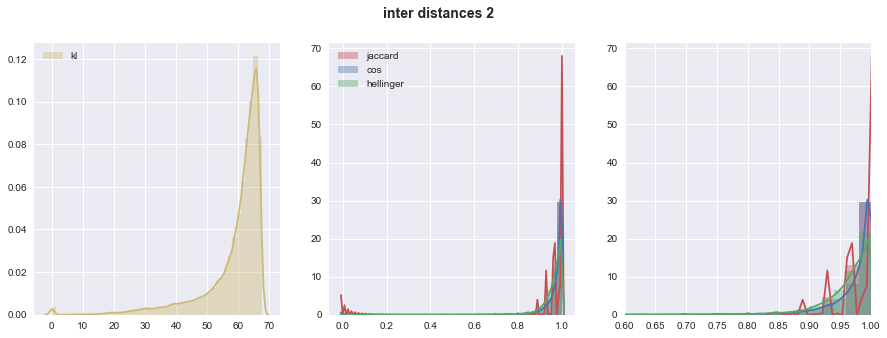

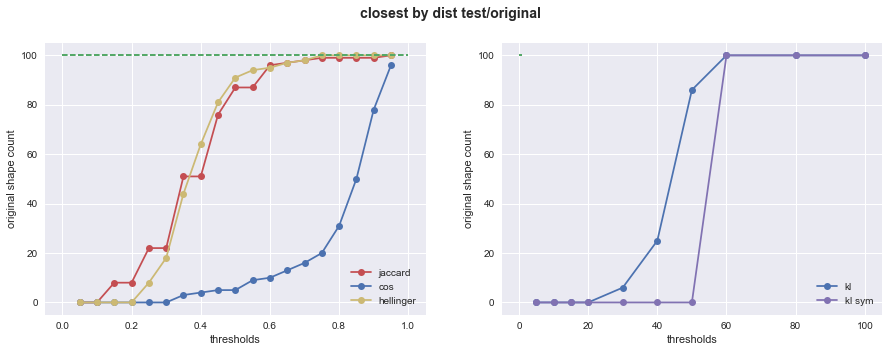

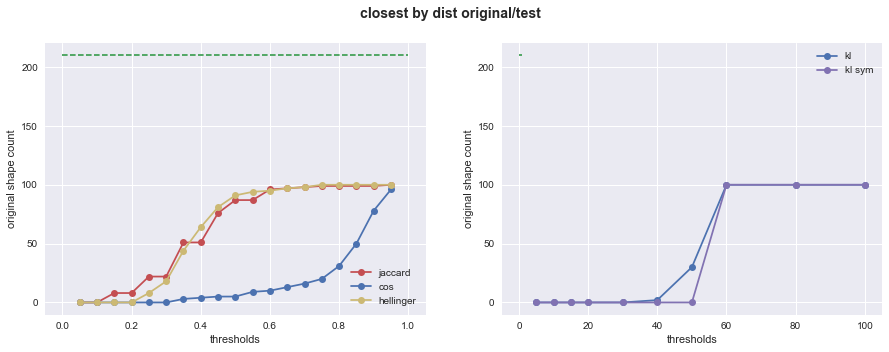

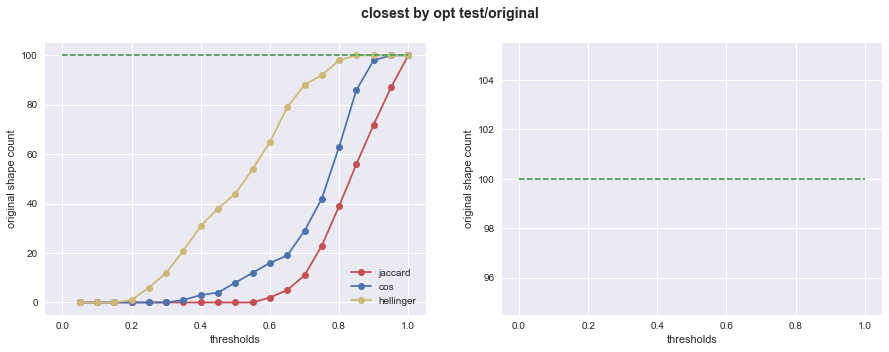

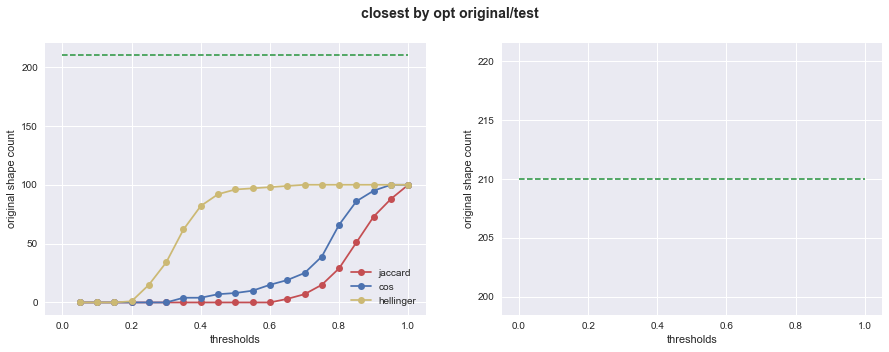

In [18]:
def create_model_rch_300_2(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 3
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 22
names_list[idx] = u'model_rch_300_2'
models_list[idx] = create_model_rch_300_2(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 
* **closest by dist test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by dist original/test**:  0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res original/test**: 0.2: ; 0.4: ; 0.6: ; 0.8: 

* **Выводы**: 
* **TODO**: 

Попробуем ещё больше декоррелятор сделать.

name = model_rch_300_3_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_300_3_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 211, [u'topic_0', u'topic_4', u'topic_5', u'topic_7', u'topic_8', u'topic_10', u'topic_12', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_22', u'topic_24', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_47', u'topic_49', u'topic_50', u'topic_51', u'topic_53', u'topic_54', u'topic_56', u'topic_58', u'topic_59', u'topic_61', u'topic_62', u'topic_63', u'topic_64', u'topic_66', 

,phi_1,phi_2
num words,2216.00,2216.00
num topics,100.00,211.00
non zero ratio,0.96,0.98
|phi_ij == 0| / n_topics,2126.43,2175.27
|phi_ij > 0.2| / n_topics,0.23,0.36
|phi_ij > 0.1| / n_topics,0.89,1.67
|phi_ij > 0.01| / n_topics,27.16,21.52
|phi_ij > 0.05| / n_topics,2.63,5.38
|phi_ij > 0.001| / n_topics,80.26,38.51
topic_kernel_average_size,23.68,10.46


Dist fn = <function kl_sym_dist at 0x000000000BCC3908>, Processed th = 100, original columns count = 211        Processing <function jaccard_dist at 0x000000000BCC3978>
Processing <function cos_dist at 0x000000000BCC3A58>
Processing <function hellinger_dist at 0x000000000BCC3AC8>
Processing <function kl_dist at 0x000000000BCC3898>
Processing <function kl_sym_dist at 0x000000000BCC3908>
Processing <function jaccard_dist at 0x000000000BCC3978>
Processing <function cos_dist at 0x000000000BCC3A58>
Processing <function hellinger_dist at 0x000000000BCC3AC8>
Processing <function kl_dist at 0x000000000BCC3898>
Processing <function kl_sym_dist at 0x000000000BCC3908>
Dist fn = <function cos_dist at 0x000000000BCC3A58>, Processed th = 1.0, original columns count = 100           Column topic_24 not optimized
Column topic_28 not optimized
Column topic_32 not optimized
Column topic_43 not optimized
Column topic_49 not optimized
Column topic_71 not optimized
Column topic_81 not optimized
Column topic

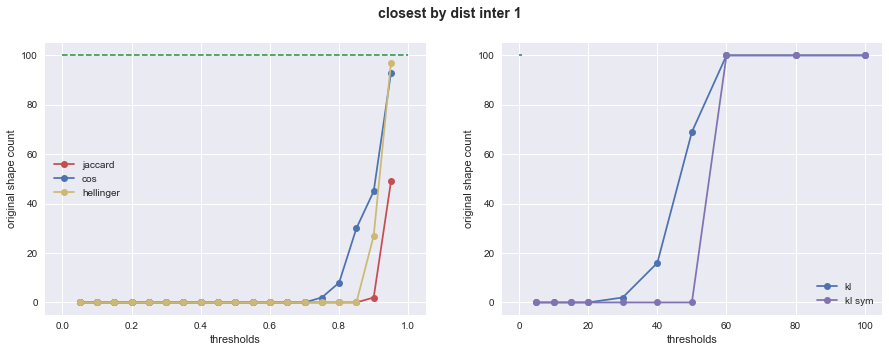

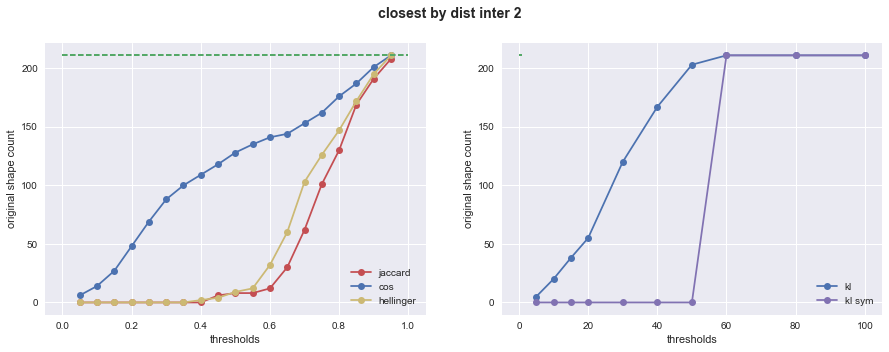

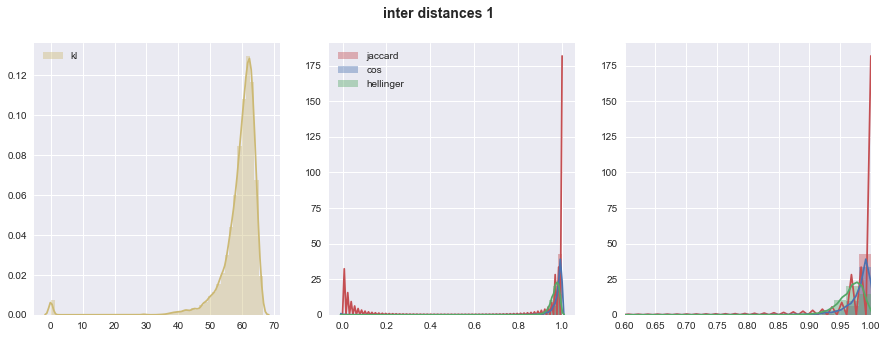

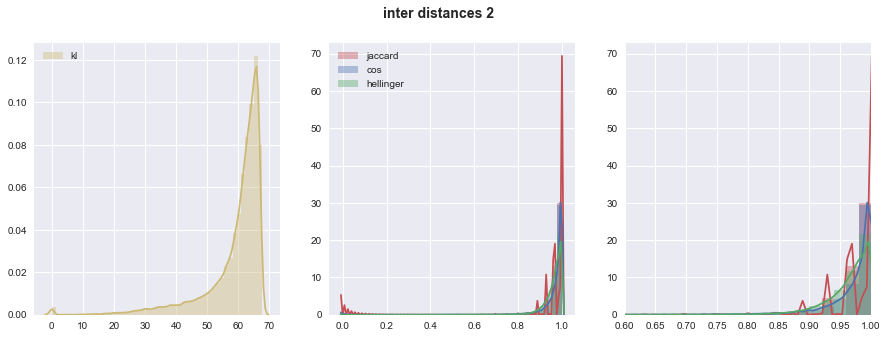

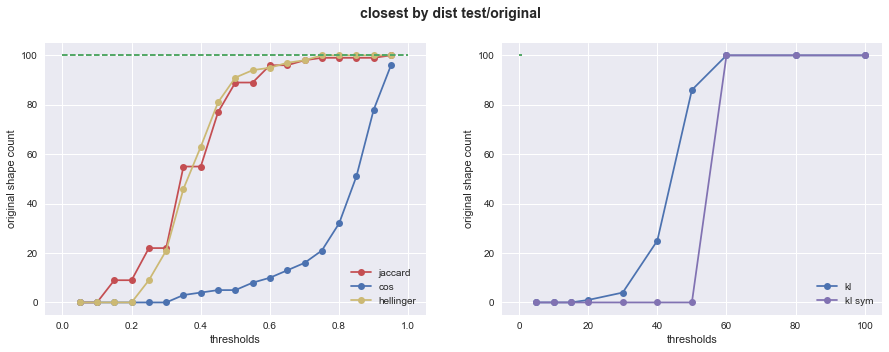

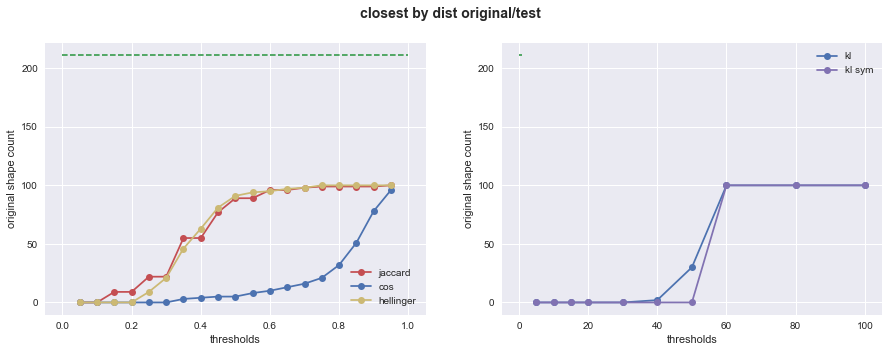

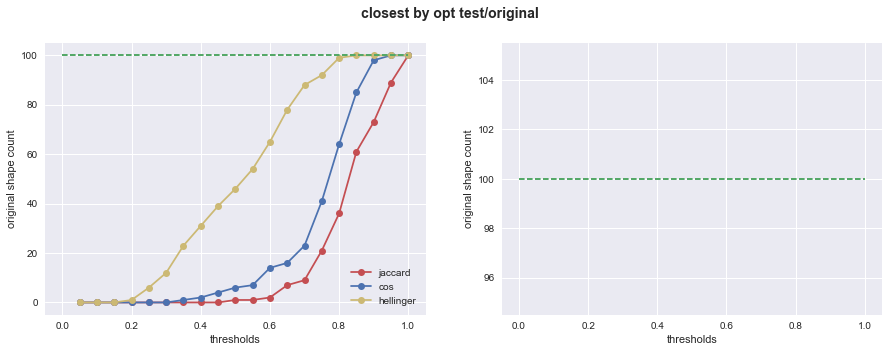

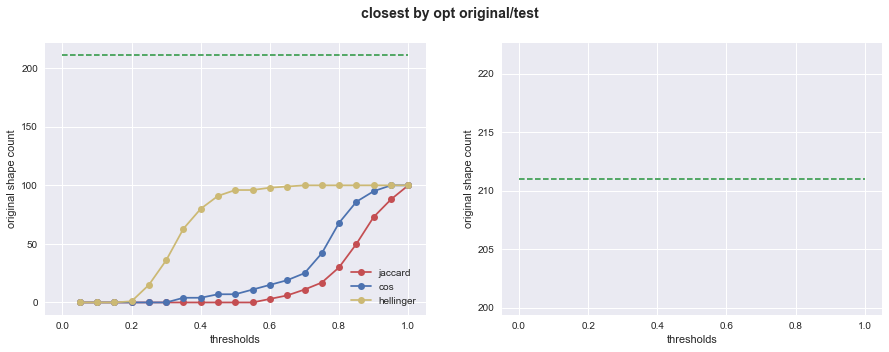

In [19]:
def create_model_rch_300_3(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 23
names_list[idx] = u'model_rch_300_3'
models_list[idx] = create_model_rch_300_3(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 
* **closest by dist test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by dist original/test**:  0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res original/test**: 0.2: ; 0.4: ; 0.6: ; 0.8: 

* **Выводы**: 
* **TODO**: 

Попробуем убрать обучение сначала.

name = model_rch_300_4_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 65, [u'topic_1', u'topic_7', u'topic_9', u'topic_13', u'topic_23', u'topic_28', u'topic_31', u'topic_33', u'topic_36', u'topic_43', u'topic_53', u'topic_56', u'topic_63', u'topic_66', u'topic_72', u'topic_84', u'topic_88', u'topic_103', u'topic_104', u'topic_107', u'topic_114', u'topic_117', u'topic_120', u'topic_125', u'topic_126', u'topic_128', u'topic_130', u'topic_135', u'topic_136', u'topic_140', u'topic_142', u'topic_146', u'topic_152', u'topic_156', u'topic_168', u'topic_184', u'topic_191', u'topic_193', u'topic_197', u'topic_199', u'topic_204', u'topic_212', u'topic_214', u'topic_215', u'topic_225', u'topic_240', u'topic_244', u'topic_247', u'topic_250', u'topic_262', u'topic_263', u'topic_264', u'topic_266

,phi_1,phi_2
num words,2216.00,2216.00
num topics,100.00,65.00
non zero ratio,0.96,0.98
|phi_ij == 0| / n_topics,2126.43,2163.15
|phi_ij > 0.2| / n_topics,0.23,0.55
|phi_ij > 0.1| / n_topics,0.89,1.85
|phi_ij > 0.01| / n_topics,27.16,21.55
|phi_ij > 0.05| / n_topics,2.63,4.25
|phi_ij > 0.001| / n_topics,80.26,47.89
topic_kernel_average_size,23.68,12.00


Dist fn = <function kl_sym_dist at 0x000000000BCC3908>, Processed th = 100, original columns count = 65        Processing <function jaccard_dist at 0x000000000BCC3978>
Processing <function cos_dist at 0x000000000BCC3A58>
Processing <function hellinger_dist at 0x000000000BCC3AC8>
Processing <function kl_dist at 0x000000000BCC3898>
Processing <function kl_sym_dist at 0x000000000BCC3908>
Processing <function jaccard_dist at 0x000000000BCC3978>
Processing <function cos_dist at 0x000000000BCC3A58>
Processing <function hellinger_dist at 0x000000000BCC3AC8>
Processing <function kl_dist at 0x000000000BCC3898>
Processing <function kl_sym_dist at 0x000000000BCC3908>
Dist fn = <function cos_dist at 0x000000000BCC3A58>, Processed th = 1.0, original columns count = 65           Column topic_72 not optimized
Column topic_114 not optimized
Column topic_284 not optimized
Dist fn = <function cos_dist at 0x000000000BCC3A58>, Processed th = 1.0, original columns count = 65           Column topic_35 not o

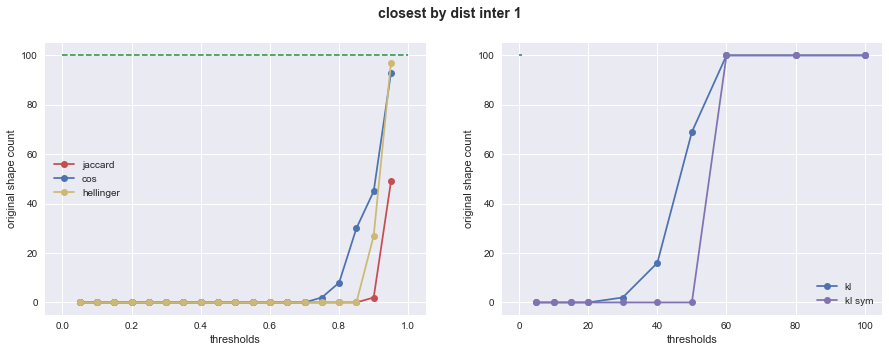

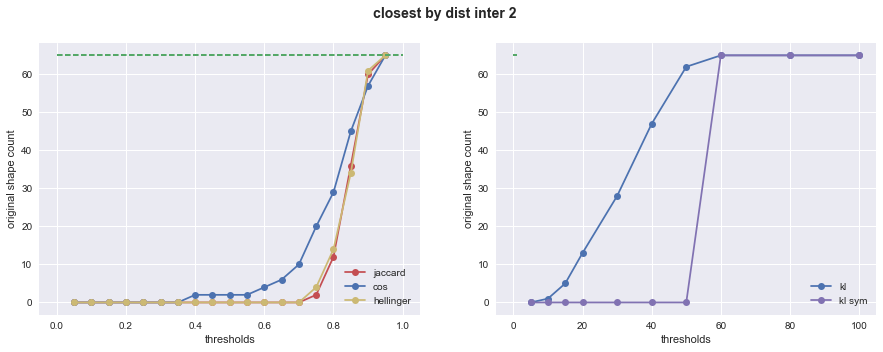

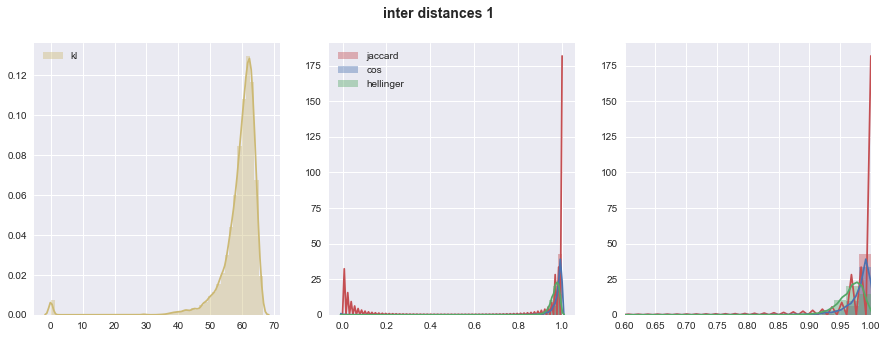

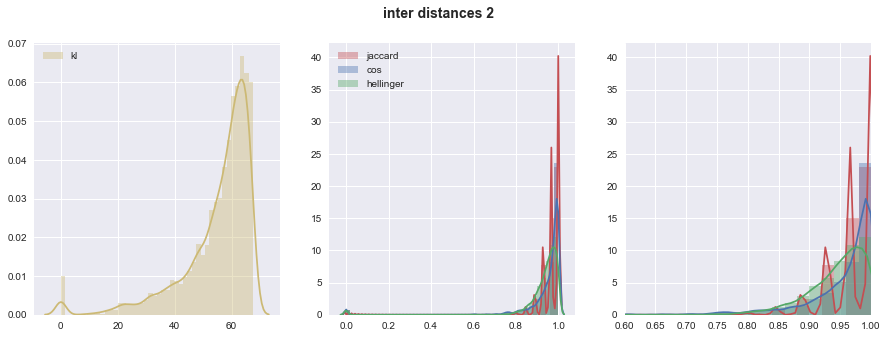

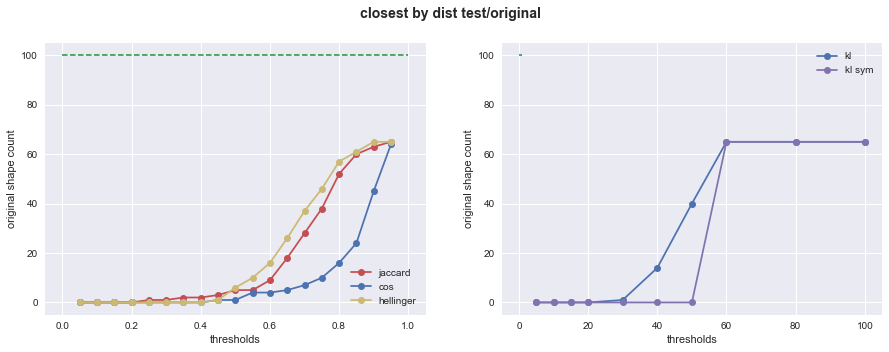

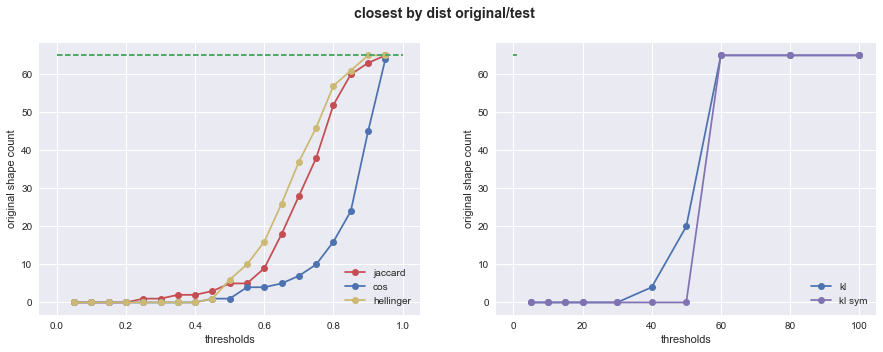

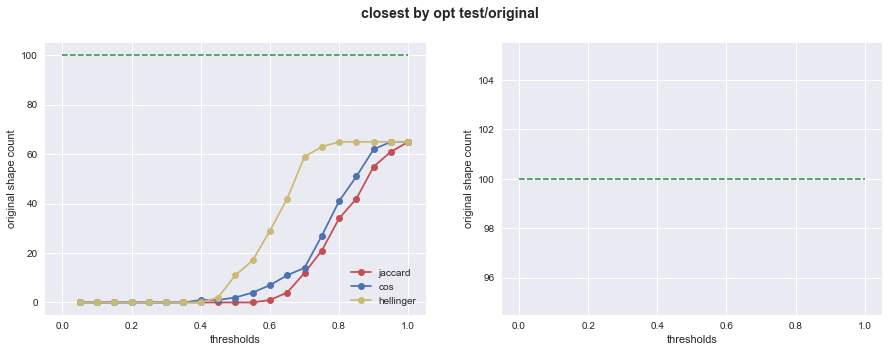

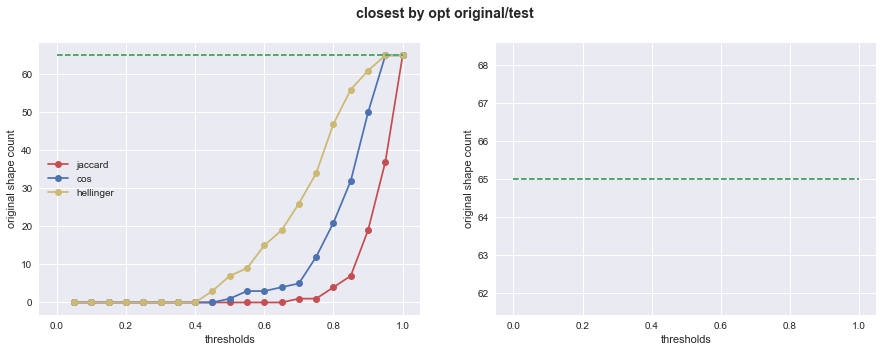

In [20]:
def create_model_rch_300_4(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 24
names_list[idx] = u'model_rch_300_4'
models_list[idx] = create_model_rch_300_4(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 
* **closest by dist test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by dist original/test**:  0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res original/test**: 0.2: ; 0.4: ; 0.6: ; 0.8: 

* **Выводы**: 
* **TODO**: 

## topic selection only
Без обучения в начале, коэф маленький (0.1)

name = model_rch_300_1_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
ss_phi_regularizer, tau = -1.5
topic_selection_theta_regularizer, tau = 0.1

('Filtered topics: ', 75, [u'topic_7', u'topic_13', u'topic_17', u'topic_20', u'topic_21', u'topic_23', u'topic_24', u'topic_25', u'topic_28', u'topic_32', u'topic_33', u'topic_36', u'topic_43', u'topic_53', u'topic_63', u'topic_66', u'topic_72', u'topic_75', u'topic_78', u'topic_84', u'topic_88', u'topic_101', u'topic_103', u'topic_104', u'topic_107', u'topic_114', u'topic_117', u'topic_120', u'topic_125', u'topic_126', u'topic_127', u'topic_128', u'topic_129', u'topic_130', u'topic_138', u'topic_140', u'topic_142', u'topic_149', u'topic_152', u'topic_156', u'topic_164', u'topic_168', u'topic_174', u'topic_181', u'topic_184', u'topic_191', u'topic_192', u'topic_197', u'topic_199', u'topic_204', u'topic_208', u'topic_212', u't

,phi_1,phi_2
num words,2216.00,2216.00
num topics,100.00,75.00
non zero ratio,0.96,0.98
|phi_ij == 0| / n_topics,2126.43,2170.25
|phi_ij > 0.2| / n_topics,0.23,0.76
|phi_ij > 0.1| / n_topics,0.89,2.16
|phi_ij > 0.01| / n_topics,27.16,18.81
|phi_ij > 0.05| / n_topics,2.63,4.31
|phi_ij > 0.001| / n_topics,80.26,41.00
topic_kernel_average_size,23.68,10.45


Dist fn = <function kl_sym_dist at 0x000000000BCC3908>, Processed th = 100, original columns count = 75        Processing <function jaccard_dist at 0x000000000BCC3978>
Processing <function cos_dist at 0x000000000BCC3A58>
Processing <function hellinger_dist at 0x000000000BCC3AC8>
Processing <function kl_dist at 0x000000000BCC3898>
Processing <function kl_sym_dist at 0x000000000BCC3908>
Processing <function jaccard_dist at 0x000000000BCC3978>
Processing <function cos_dist at 0x000000000BCC3A58>
Processing <function hellinger_dist at 0x000000000BCC3AC8>
Processing <function kl_dist at 0x000000000BCC3898>
Processing <function kl_sym_dist at 0x000000000BCC3908>
Dist fn = <function cos_dist at 0x000000000BCC3A58>, Processed th = 1.0, original columns count = 75           Column topic_23 not optimized
Column topic_28 not optimized
Column topic_84 not optimized
Column topic_101 not optimized
Column topic_114 not optimized
Column topic_277 not optimized
Column topic_287 not optimized
Dist fn = 

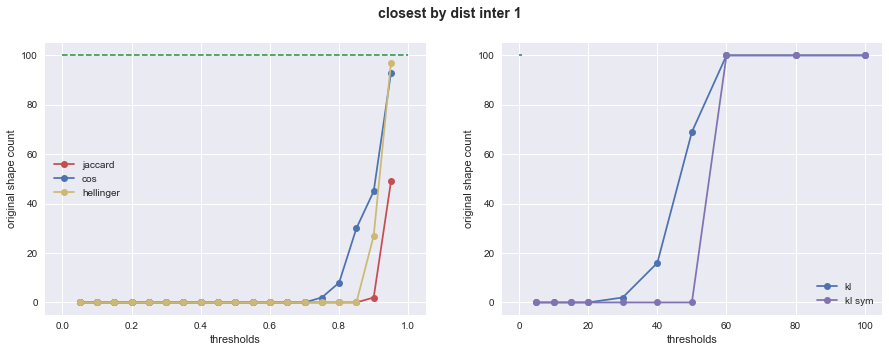

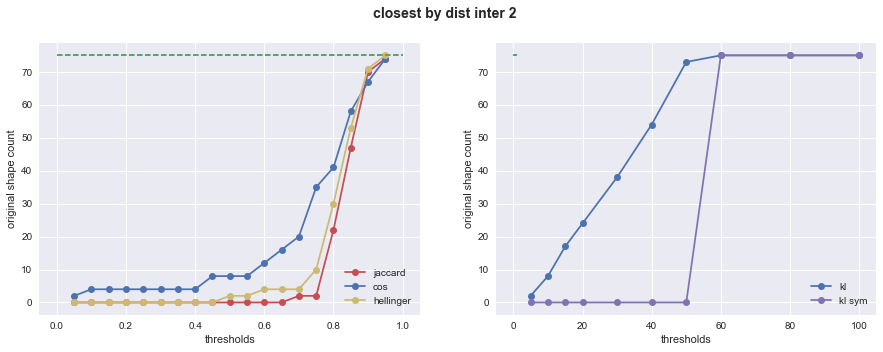

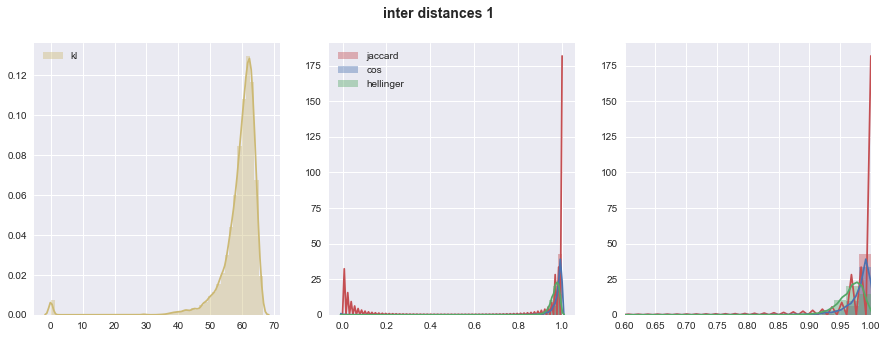

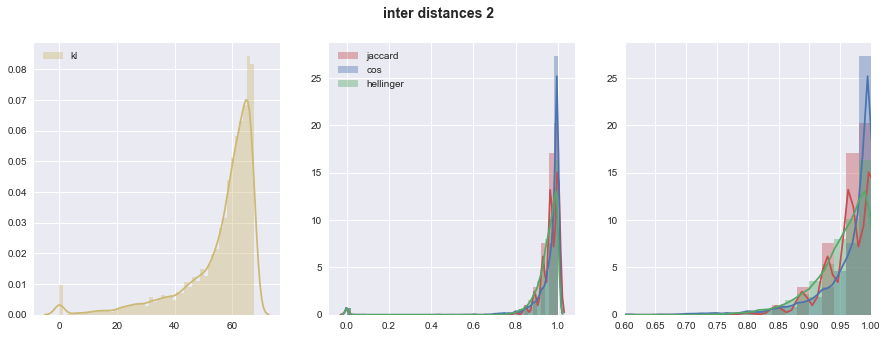

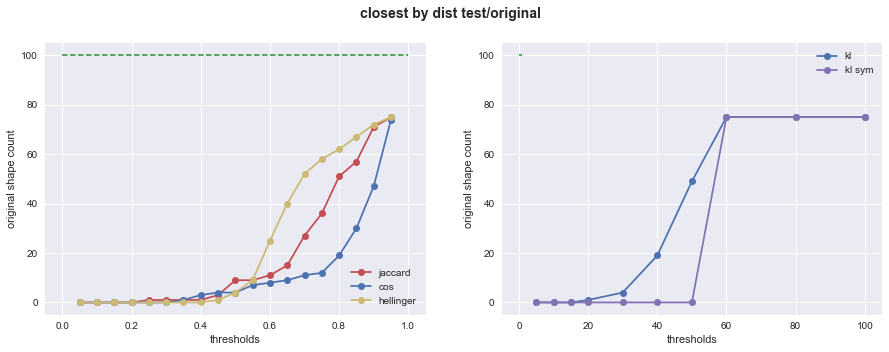

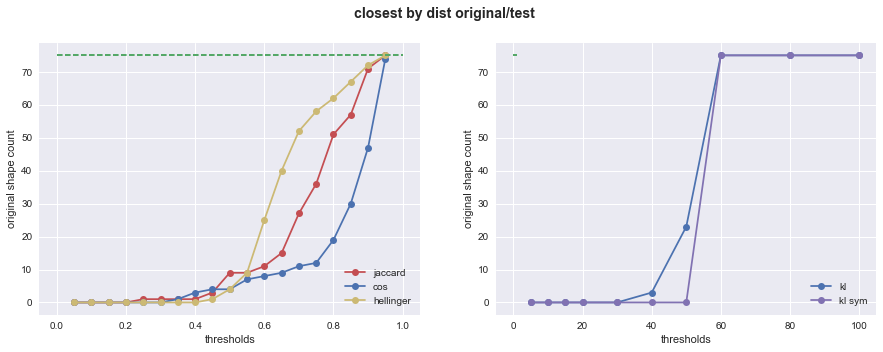

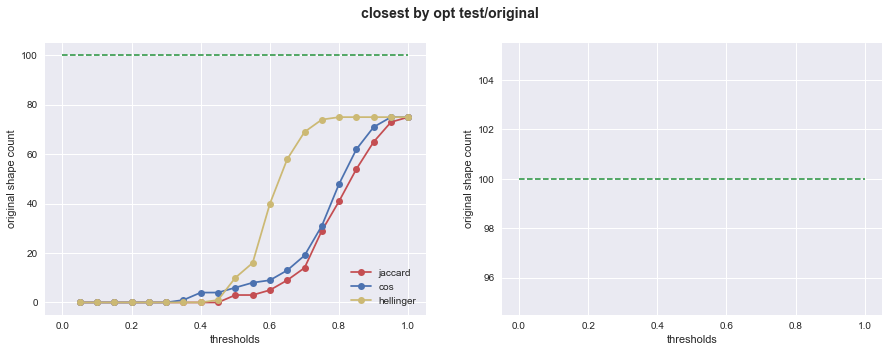

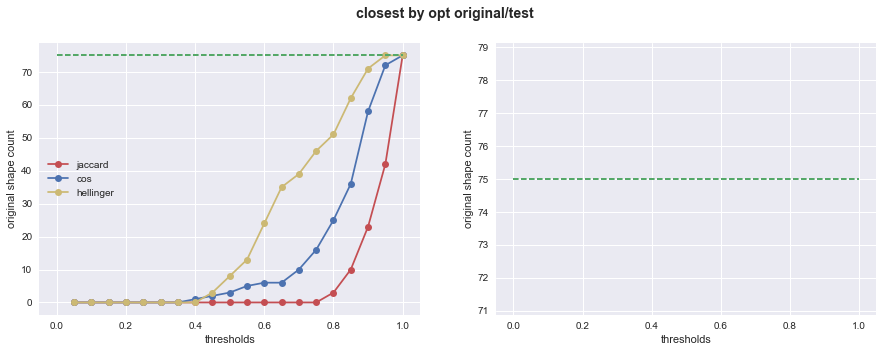

In [ ]:
def create_model_rch_300_1_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.1
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 31
names_list[idx] = u'model_rch_300_1_ts'
models_list[idx] = create_model_rch_300_1_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 
* **closest by dist test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by dist original/test**:  0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res original/test**: 0.2: ; 0.4: ; 0.6: ; 0.8: 

* **Выводы**: 
* **TODO**: 

Увеличим коэф (с 0 0.1 до 0.5) + начальное обучение без регуляризаторов.

In [ ]:
def create_model_rch_300_2_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 32
names_list[idx] = u'model_rch_300_2_ts'
models_list[idx] = create_model_rch_300_2_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

name = model_rch_300_2_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_300_2_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
ss_phi_regularizer, tau = -1.5
topic_selection_theta_regularizer, tau = 0.5

('Filtered topics: ', 171, [u'topic_0', u'topic_4', u'topic_5', u'topic_7', u'topic_8', u'topic_10', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_22', u'topic_24', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_49', u'topic_50', u'topic_51', u'topic_54', u'topic_56', u'topic_58', u'topic_59', u'topic_61', u'topic_62', u'topic_63', u'topic_66', u'topic_68', u'topic_70', u'topic_71', u'topic_74', u'topic_76', 

,phi_1,phi_2
num words,2216.00,2216.00
num topics,100.00,171.00
non zero ratio,0.96,0.98
|phi_ij == 0| / n_topics,2126.43,2161.85
|phi_ij > 0.2| / n_topics,0.23,0.35
|phi_ij > 0.1| / n_topics,0.89,1.38
|phi_ij > 0.01| / n_topics,27.16,23.29
|phi_ij > 0.05| / n_topics,2.63,4.36
|phi_ij > 0.001| / n_topics,80.26,49.69
topic_kernel_average_size,23.68,12.92


Dist fn = <function kl_sym_dist at 0x000000000BCC3908>, Processed th = 60, original columns count = 171    8    

* 150 -> 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 
* **closest by dist test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by dist original/test**:  0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res original/test**: 0.2: ; 0.4: ; 0.6: ; 0.8: 

* **Выводы**: 
* **TODO**: 

Увеличить спарсе коэффициенты (от -1.5 до -2)

In [ ]:
def create_model_rch_300_3_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 33
names_list[idx] = u'model_rch_300_3_ts'
models_list[idx] = create_model_rch_300_3_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 
* **closest by dist test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by dist original/test**:  0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res original/test**: 0.2: ; 0.4: ; 0.6: ; 0.8: 

* **Выводы**: 
* **TODO**: 

Увеличим коэффициент отбора тем от 0.5 до 0.7

In [ ]:
def create_model_rch_300_4_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.7
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 34
names_list[idx] = u'model_rch_300_4_ts'
models_list[idx] = create_model_rch_300_4_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 
* **closest by dist test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by dist original/test**:  0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res original/test**: 0.2: ; 0.4: ; 0.6: ; 0.8: 

* **Выводы**: 
* **TODO**: 

Без регуляризаторов

In [ ]:
def create_model_rch_300_5_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)   
    return tmp_model

idx = 35
names_list[idx] = u'model_rch_300_5_ts'
models_list[idx] = create_model_rch_300_5_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 
* **closest by dist test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by dist original/test**:  0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res original/test**: 0.2: ; 0.4: ; 0.6: ; 0.8: 

* **Выводы**: 
* **TODO**: 

## decorrelator + topic selection

In [ ]:
def create_model_rch_300_1_decor_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=15, 
                                  _model_name=model_name)
    
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.7
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 41
names_list[idx] = u'create_model_rch_300_1_decor_ts'
models_list[idx] = create_model_rch_300_1_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 
* **closest by dist test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by dist original/test**:  0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res original/test**: 0.2: ; 0.4: ; 0.6: ; 0.8: 

* **Выводы**: 
* **TODO**: 

Спарсе по -1,5 для сравнения с без топик селектиона

In [ ]:
def create_model_rch_300_2_decor_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.7
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 42
names_list[idx] = u'create_model_rch_300_2_decor_ts'
models_list[idx] = create_model_rch_300_2_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 
* **closest by dist test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by dist original/test**:  0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res original/test**: 0.2: ; 0.4: ; 0.6: ; 0.8: 

* **Выводы**: 
* **TODO**: 

увеличим топик селекьтон коэф


In [ ]:
def create_model_rch_300_3_decor_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=15, 
                                  _model_name=model_name)
    
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.9
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 41
names_list[idx] = u'create_model_rch_300_3_decor_ts'
models_list[idx] = create_model_rch_300_3_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 
* **closest by dist test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by dist original/test**:  0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res original/test**: 0.2: ; 0.4: ; 0.6: ; 0.8: 

* **Выводы**: 
* **TODO**: 

In [ ]:
save_pickle_file([different_inter_distances_closest_1, different_inter_distances_closest_2, 
        different_inter_distances_1, different_inter_distances_2, 
        different_to_original_distances_closest_1, different_to_test_distances_closest_2, 
        different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix], 'result_300.p')
save_pickle_file([names_list, phi_list, phi_nwt_list, theta_list,
                  phi_filtered_list, phi_nwt_filtered_list, theta_filtered_list], 'init_300.p')